Summary:

- Implemented proposed calibration API by performing a code refactor on generate_with_calibration.py. 
- Performed experiments on calibration curve blowup for different values of top k
- Examined what calibration does qualitatively

TODO:

- Find alpha based using minimization of the cross-entropy loss
- Implement script with multi-GPU
- Implement beam search for two-step lookahead

In [1]:
%matplotlib inline

import os
import sys
sys.path.append('../examples')

import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [2]:
import run_generation_2 as gen

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


# Experiment 1: Entropy blowup curves top k values

- Top k values: 128, 256, 512, 1024
- 1000 independent samples, all 
- length 100, all

In [ ]:
%%capture
ents128 = gen.run("To be or not to be, that is the question:", num_samples=1000, alpha=-0.01, top_k=128) 

11/05/2019 08:27:05 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /u/myhu/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
11/05/2019 08:27:05 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /u/myhu/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
11/05/2019 08:27:05 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
11/05/2019 0

Text(0.5, 1.0, 'Entropy blowup, top 128 filtering')

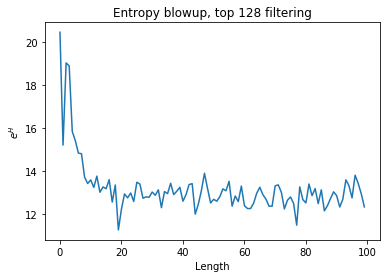

In [10]:
avg_ents = ents128.cpu().numpy()[0]

figure, axis = plt.subplots()
axis.plot(np.exp(avg_ents))
axis.set_xlabel('Length')
axis.set_ylabel('$e^H$')
axis.set_title('Entropy blowup, top 128 filtering')

Text(0.5, 1.0, 'Entropy blowup, top 128 filtering')

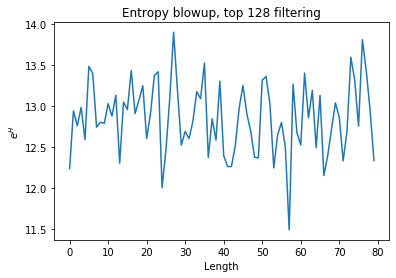

In [11]:
figure, axis = plt.subplots()
axis.plot(np.exp(avg_ents[20:]))
axis.set_xlabel('Length')
axis.set_ylabel('$e^H$')
axis.set_title('Entropy blowup, top 128 filtering')

In [12]:
ents128

tensor([[3.0181, 2.7222, 2.9459, 2.9386, 2.7630, 2.7351, 2.6973, 2.6954, 2.6194,
         2.5973, 2.6098, 2.5837, 2.6226, 2.5667, 2.5853, 2.5793, 2.6105, 2.5311,
         2.5923, 2.4225, 2.5048, 2.5607, 2.5466, 2.5640, 2.5333, 2.6018, 2.5955,
         2.5453, 2.5500, 2.5489, 2.5675, 2.5558, 2.5754, 2.5102, 2.5690, 2.5619,
         2.5982, 2.5583, 2.5706, 2.5842, 2.5343, 2.5581, 2.5937, 2.5969, 2.4856,
         2.5229, 2.5725, 2.6322, 2.5800, 2.5278, 2.5412, 2.5343, 2.5507, 2.5787,
         2.5721, 2.6049, 2.5159, 2.5532, 2.5328, 2.5883, 2.5176, 2.5069, 2.5068,
         2.5273, 2.5633, 2.5844, 2.5580, 2.5417, 2.5161, 2.5154, 2.5893, 2.5927,
         2.5672, 2.5055, 2.5381, 2.5497, 2.5260, 2.4418, 2.5857, 2.5400, 2.5281,
         2.5957, 2.5542, 2.5799, 2.5255, 2.5752, 2.4979, 2.5178, 2.5440, 2.5683,
         2.5546, 2.5126, 2.5413, 2.6100, 2.5895, 2.5464, 2.6257, 2.5978, 2.5613,
         2.5129]], device='cuda:0')

In [13]:
np.savez('110519_top128.npz', avg_ents)

The above method simply uses entropy as a penalty, subtracting it from the probability. We then sample from this new distribution. This is not the way calibration is done in the paper (I misunderstood the purpose of the script). Nonetheless, the results of this experiment look promising as well, and may be a direction that we can examine in the future.